C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [11:32:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)


------------Test Prediction--------------
Classfication Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.79      0.87        98

    accuracy                           1.00     56962
   macro avg       0.99      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962



Accuracy Score: 99.96%
------------Training Prediction--------------
Classfication Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00       394

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845



Accuracy Score: 100.00%


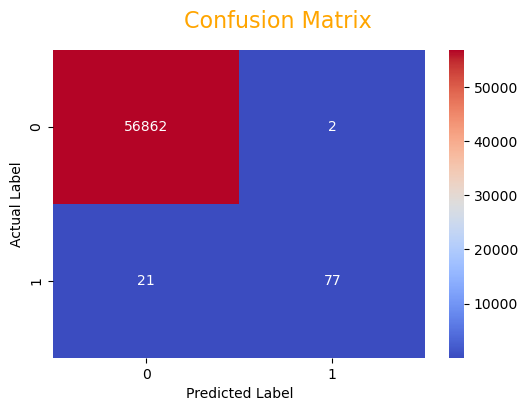

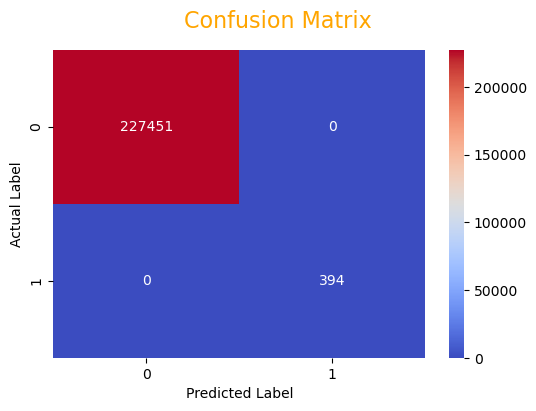

In [2]:
import random
from deap import base, creator, tools, algorithms
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import precision_recall_curve, auc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load the dataset from a CSV file
df = pd.read_csv('creditcard.csv')

# Split the dataset into features (X) and the target variable (y)
X = df.drop('Class', axis=1).values 
y = df['Class'].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the evaluation function (fitness function) using XGBoost
def evaluate(individual, X, y):
    # Create a mask to select features
    
    mask = [bool(bit) for bit in individual]
    X_selected = X[:, mask]

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)


    # Train an XGBoost classifier
    clf = xgb.XGBClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_preds = clf.predict(X_test)

    # Calculate precision-recall AUC
    y_score = clf.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    auc_score = auc(recall, precision)

    return auc_score,

# Create a fitness function (maximize AUC)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Genetic algorithm toolbox setup
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=30)  # 30 features
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate, X=X_train, y=y_train)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=30)

# Create the population
population = toolbox.population(n=50)

# Define the number of generations
n_generations = 20

# Main genetic algorithm
for gen in range(n_generations):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.7, mutpb=0.2)
    fits = toolbox.map(toolbox.evaluate, offspring)

    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit

    population = toolbox.select(offspring, k=len(population))

# Retrieve the best individual (features)
best_individual = tools.selBest(population, k=1)[0]
best_feature_mask = [bool(bit) for bit in best_individual]

# Use the best feature subset for model training and testing
X_selected = X_train[:, best_feature_mask]
X_test_selected = X_test[:, best_feature_mask]

clf = xgb.XGBClassifier(n_estimators=100, random_state=42, max_features=len(best_feature_mask))

clf.fit(X_selected, y_train)
y_preds = clf.predict(X_test_selected)

# Classification report, confusion matrix, and accuracy score for test data
print("------------Test Prediction--------------")
print(f"Classfication Report:\n\n{classification_report(y_test, y_preds)}\n\n")
cf_matrix = confusion_matrix(y_test, y_preds)
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(cf_matrix, annot=True, cmap='coolwarm', fmt='g')
fig.suptitle(t="Confusion Matrix", color="orange", fontsize=16)
ax.set(xlabel="Predicted Label", ylabel="Actual Label")
accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy Score: {accuracy * 100:.2f}%")

# Classification report, confusion matrix, and accuracy score for training data
print("------------Training Prediction--------------")
y_preds_train = clf.predict(X_selected)


print(f"Classfication Report:\n\n{classification_report(y_train, y_preds_train)}\n\n")
cf_matrix_train = confusion_matrix(y_train, y_preds_train)
fig_train, ax_train = plt.subplots(figsize=(6, 4))


sns.heatmap(cf_matrix_train, annot=True, cmap='coolwarm', fmt='g')
fig_train.suptitle(t="Confusion Matrix", color="orange", fontsize=16)
ax_train.set(xlabel="Predicted Label", ylabel="Actual Label")
accuracy_train = accuracy_score(y_train, y_preds_train)
print(f"Accuracy Score: {accuracy_train * 100:.2f}%")